## 1. Image Augmentation
## 2. Modeling
## 3. Explainable AI (intermediate layers and gradient class activation mapping)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import imutils
import cv2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import random
import os

In [2]:
tf.__version__

'2.1.0'

In [3]:
train_igen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, 
                         width_shift_range=0.2, height_shift_range=0.2)

In [4]:
test_igen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, 
                         width_shift_range=0.2, height_shift_range=0.2)

In [5]:
train_dir = "data/train/"
test_dir = "data/test/"


In [6]:
classes = []
for filename in os.listdir(train_dir):
    classes.append(filename)

In [7]:
ear_train_dir = os.path.join(train_dir, 'human_ear')
feet_train_dir = os.path.join(train_dir, 'human_feet')
mouth_train_dir = os.path.join(train_dir, 'human_mouth')
eye_train_dir = os.path.join(train_dir, 'human_eye') 
finger_train_dir = os.path.join(train_dir, 'human_finger')

In [8]:
ear_pix = os.listdir(ear_train_dir)
feet_pix = os.listdir(feet_train_dir)
mouth_pix = os.listdir(mouth_train_dir)
eye_pix = os.listdir(eye_train_dir)
finger_pix = os.listdir(finger_train_dir)


In [9]:
import matplotlib.image as im

#### Training images:

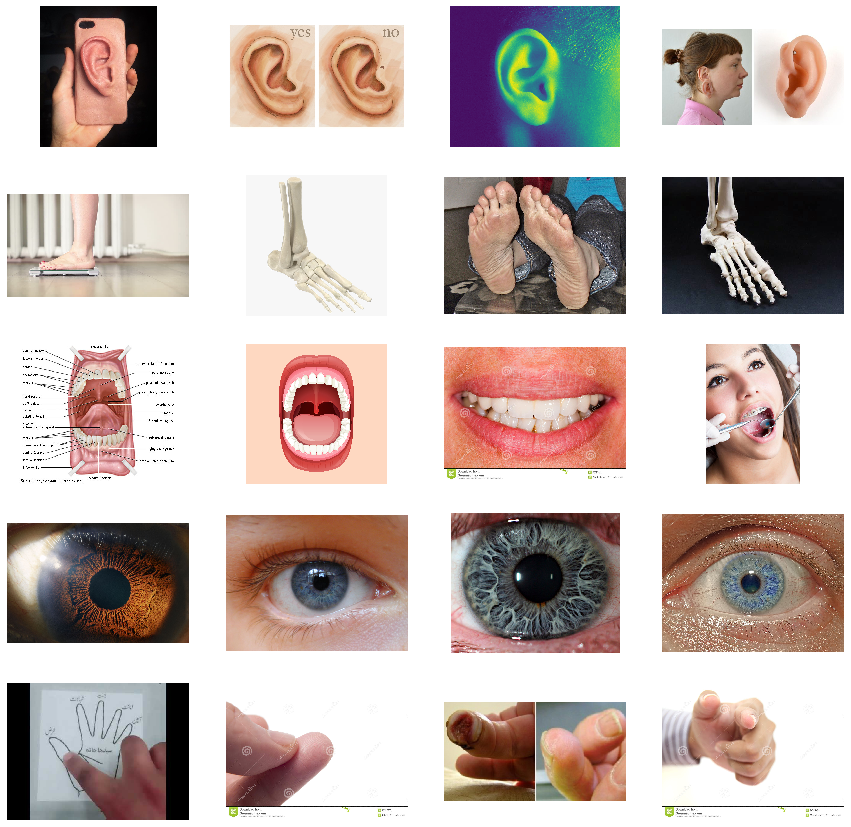

In [10]:
pic_index=4+15
nrows = len(classes)
ncols = 4


plt.figure(figsize=(15,15))

next_ear_pix = [os.path.join(ear_train_dir, fname) for fname in ear_pix[15:pic_index] ]
next_feet_pix = [os.path.join(feet_train_dir, fname) for fname in feet_pix[15:pic_index] ]
next_mouth_pix = [os.path.join(mouth_train_dir, fname) for fname in mouth_pix[15:pic_index] ]
next_eye_pix = [os.path.join(eye_train_dir, fname) for fname in eye_pix[15:pic_index] ]
next_finger_pix = [os.path.join(finger_train_dir, fname) for fname in finger_pix[18:pic_index+3] ]


for i, img_path in enumerate(next_ear_pix+next_feet_pix+next_mouth_pix+next_eye_pix+next_finger_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = plt.imread(img_path)
    plt.imshow(img)

plt.show()


In [11]:
train_gen = train_igen.flow_from_directory(train_dir, batch_size=16, target_size=(150,150), class_mode='categorical')

Found 703 images belonging to 5 classes.


In [12]:
test_gen = test_igen.flow_from_directory(test_dir, batch_size=16, target_size=(150,150), class_mode='categorical')

Found 237 images belonging to 5 classes.


### Training Image Classifier using Transfer Learning:

In [17]:
conv_base1 = tf.keras.applications.ResNet50(include_top=False,
                  input_shape=(150, 150, 3))

model1 = tf.keras.models.Sequential()
model1.add(conv_base1)
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dropout(0.35))
model1.add(tf.keras.layers.Dense(256, activation='relu'))
model1.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

conv_base1.trainable = False

model1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-3),
              metrics=['acc'])

In [18]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 36,696,453
Trainable params: 13,108,741
Non-trainable params: 23,587,712
_________________________________________________________________


### CNN from scratch:

In [13]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(5, activation='softmax')  )

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              metrics=['acc'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [15]:
history = model.fit(train_gen,
                      validation_data=test_gen,
                      epochs=100)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 44 steps, validate for 15 steps
Epoch 1/100
44/44 [==============================] - 34s 782ms/step - loss: 1.6364 - acc: 0.2745 - val_loss: 1.4915 - val_acc: 0.2532
Epoch 2/100
44/44 [==============================] - 34s 771ms/step - loss: 1.4932 - acc: 0.3542 - val_loss: 1.3781 - val_acc: 0.4641
Epoch 3/100
44/44 [==============================] - 33s 753ms/step - loss: 1.3009 - acc: 0.4595 - val_loss: 1.3285 - val_acc: 0.4304
Epoch 4/100
44/44 [==============================] - 33s 758ms/step - loss: 1.2374 - acc: 0.5021 - val_loss: 1.1184 - val_acc: 0.5570
Epoch 5/100
44/44 [==============================] - 33s 760ms/step - loss: 1.1581 - acc: 0.5292 - val_loss: 1.1846 - val_acc: 0.5232
Epoch 6/100
44/44 [==============================] - 33s 757ms/step - loss: 1.0833 - acc: 0.5448 - val_loss: 1.0636 - val_acc: 0.5949
Epoch 7/100
44/44 [==============================] - 34s 769ms/step - loss: 1.0607 - acc: 0.5576 - val_l

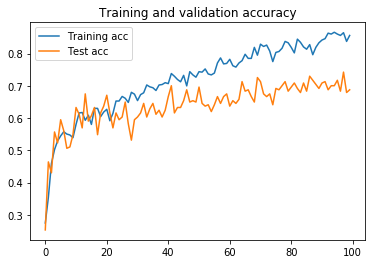

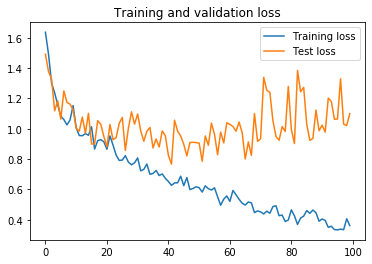

In [16]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs


plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Test acc')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Test loss')
plt.title('Training and validation loss')
plt.legend()

In [17]:
model.save('img_classifier.h5')

In [20]:
tf.keras.models.load_model('img_classifier.h5')

#### CNN Findings:

1. With lr = 2e-5 the val_acc was bouncing between 0.15-0.25 maxing out at 27%. (transfer learning)
2. With lr = 1e-3 the val_acc was stuck at 0.24. (tl)
3. In both above cases, the train_acc was at 90%+.
4. Creating CNN from scratch has reduced overfitting problem.

## Explainable AI

* It is important to identify what the Convolution layers are looking at, we do that by viewing the intermediate layers of our saved model developed from scratch

#### Layers in the model

In [21]:
[layer.output.shape for layer in model.layers[1:]]

[TensorShape([None, 74, 74, 16]),
 TensorShape([None, 72, 72, 32]),
 TensorShape([None, 36, 36, 32]),
 TensorShape([None, 34, 34, 64]),
 TensorShape([None, 17, 17, 64]),
 TensorShape([None, 18496]),
 TensorShape([None, 512]),
 TensorShape([None, 512]),
 TensorShape([None, 5])]

In [22]:
successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# A random image from eye class is taken
img_path = random.choice(next_eye_pix)
img = load_img(img_path, target_size=(150, 150))  

x = img_to_array(img)   
print(x.shape)
x = x.reshape((1,) + x.shape)               
print(x.shape[1])
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)
print(successive_feature_maps[0].shape)
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

(150, 150, 3)
150
(1, 74, 74, 16)


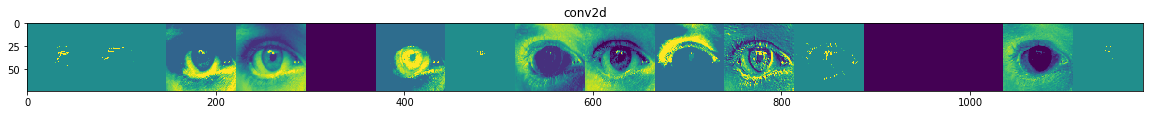

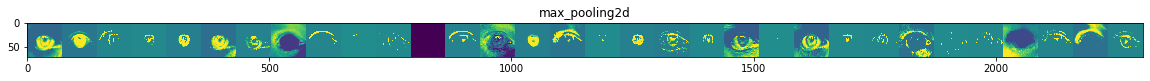

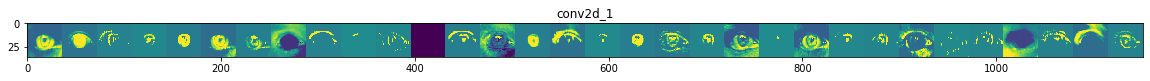

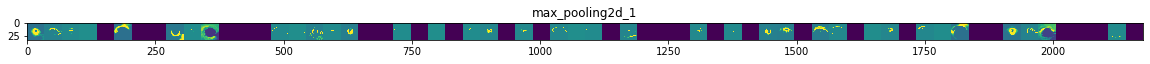

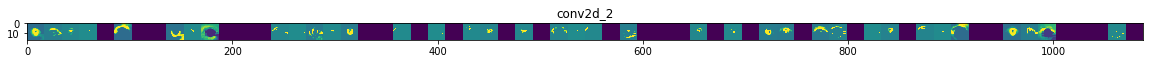

In [23]:
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    # Convolution and MaxPooling has 4 dimensions
    if len(feature_map.shape) == 4:
    
        n_features = feature_map.shape[-1]  
        size = feature_map.shape[1]          
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x 

        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.imshow(display_grid, aspect='auto', cmap='viridis' ) 

### Gradient Class Activation Mapping 

In [163]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
   
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = tf.keras.models.Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                     self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_PLASMA):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)


In [167]:
img_path = random.choice(next_ear_pix)
img = load_img(img_path, target_size=(150, 150))  

x = img_to_array(img)   
x = x.reshape((1,) + x.shape)               
x /= 255.0

orig = plt.imread(img_path)

# use the network to make predictions on the input imag and find
# the class label index with the largest corresponding probability
preds = model.predict(x)
i = np.argmax(preds[0])
lab = ["ear", "eye", "feet", "finger", "mouth"]
prob = preds[0][i]

In [168]:
label = "{}: {:.2f}%".format(lab[i], prob * 100)

# initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(x)

# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# display the original image and resulting heatmap and output image
# to our screen
output = np.hstack([orig, heatmap, output])

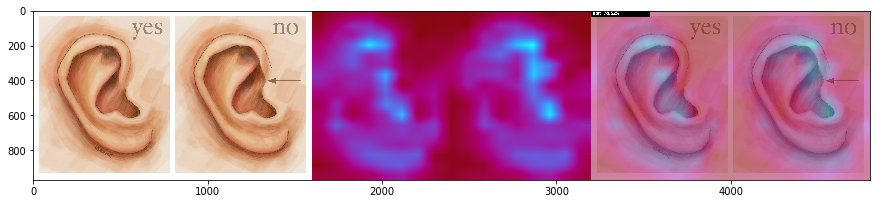

In [169]:
plt.figure(figsize=(15, 15))
plt.imshow(output)